In [40]:
# Module 4: Time Series Analysis and EOF Analysis
# Load and process ERA5 SST and TCWV data

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from eofs.xarray import Eof

# Load the NetCDF file
ds = xr.open_dataset("8a87b5a45bb81ffe9f772b440b9194e7.nc")
print("Dataset loaded:")
print(ds)


Dataset loaded:
<xarray.Dataset> Size: 551MB
Dimensions:     (valid_time: 549, latitude: 521, longitude: 241)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2025-09-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 2kB 60.0 60.25 60.5 ... 119.5 119.8 120.0
    expver      (valid_time) <U4 9kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 276MB ...
    tcwv        (valid_time, latitude, longitude) float32 276MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-22T22:44 GRIB to CDM+CF via cfgrib-0.9.1...


In [45]:
ds

<xarray.Dataset> Size: 551MB
Dimensions:     (valid_time: 549, latitude: 521, longitude: 241)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2025-09-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 2kB 60.0 60.25 60.5 ... 119.5 119.8 120.0
    expver      (valid_time) <U4 9kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 276MB ...
    tcwv        (valid_time, latitude, longitude) float32 276MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-22T22:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [41]:
# Define helper functions for detrending and anomaly calculation

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    """Convert time to float seconds since first timestamp."""
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})
        mask = da.notnull()
        t_b = t.broadcast_like(da)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

In [57]:
# Data processing: Linear detrending and anomaly calculation
# Load data without dask chunking to avoid chunking inconsistencies

print("Loading data without dask chunking...")
ds_no_dask = xr.open_dataset("1943ba584a28f89f507dad731a693291.nc", chunks=None)
print("Dataset loaded without dask chunking")

# Linear detrending
print("Applying linear detrending...")
detr = linear_detrend(ds_no_dask[["sst", "tcwv"]], time_dim="valid_time")
print("Detrending completed")

# Calculate monthly anomalies and z-scores
print("Computing monthly anomalies...")
base_period = ("1979-01-01", "2020-12-31")
clim_src = detr.sel({"valid_time": slice(*base_period)})

# Compute monthly climatology
clim_mean = clim_src.groupby("valid_time.month").mean("valid_time", skipna=True)
clim_std = clim_src.groupby("valid_time.month").std("valid_time", skipna=True, ddof=1)

# Compute anomalies
anom = detr.groupby("valid_time.month") - clim_mean

# Compute z-scores
eps = 1e-6
safe_std = xr.where(clim_std > eps, clim_std, np.nan)
z = anom.groupby("valid_time.month") / safe_std

print("Success! Anomaly calculation completed.")
print(f"Anomaly dataset: {type(anom)} with variables: {list(anom.data_vars)}")
print(f"Z-score dataset: {type(z)} with variables: {list(z.data_vars)}")

Loading data without dask chunking...
Dataset loaded without dask chunking
Applying linear detrending...
Detrending completed
Computing monthly anomalies...


/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 

Success! Anomaly calculation completed.
Anomaly dataset: <class 'xarray.core.dataset.Dataset'> with variables: ['sst', 'tcwv']
Z-score dataset: <class 'xarray.core.dataset.Dataset'> with variables: ['sst', 'tcwv']


In [58]:
# EOF Analysis of SST Anomalies

print("Starting EOF analysis...")

# Extract SST anomalies for EOF analysis
sst_anom = anom['sst']

# Compute mask to exclude gridpoints with all NaNs in time
spatial_mask = ~sst_anom.isnull().all(dim='valid_time')

# Apply mask so EOF analysis is confined to ocean points
sst_masked = sst_anom.where(spatial_mask)

# Define cosine(latitude) weights following M04N05 
coslat = np.cos(np.deg2rad(sst_masked.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]  # shape (lat, 1)

# Create the EOF solver using anomaly field and weights
solver = Eof(sst_masked, weights=wgts)

# Compute first 10 EOFs and their explained variance
n_eofs = 10
eof_maps = solver.eofs(neofs=n_eofs)
variance_frac = solver.varianceFraction().values[:n_eofs]

print("EOF analysis completed successfully!")


Starting EOF analysis...
EOF analysis completed successfully!


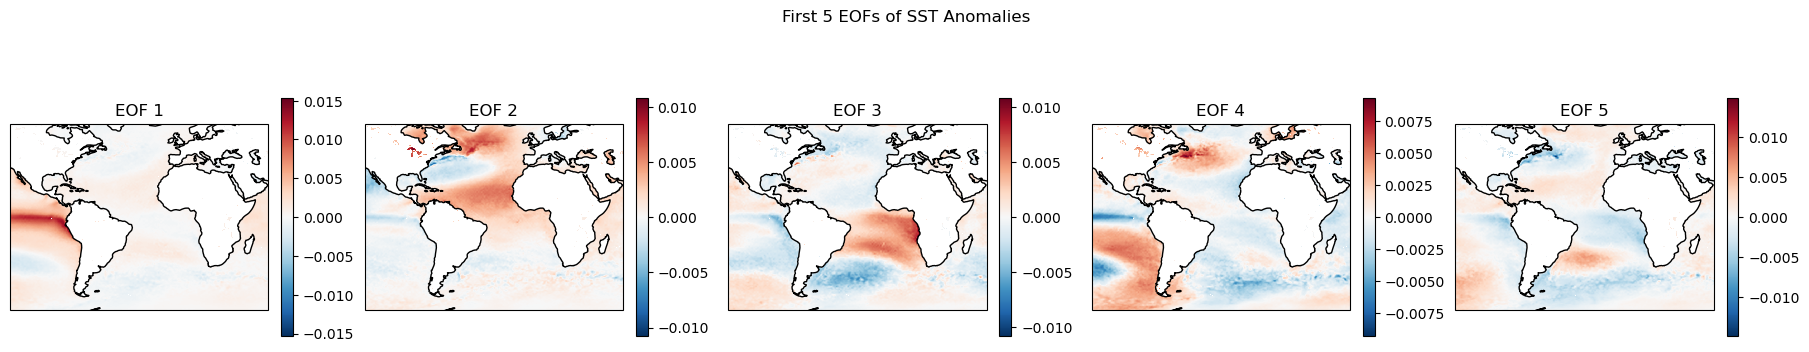

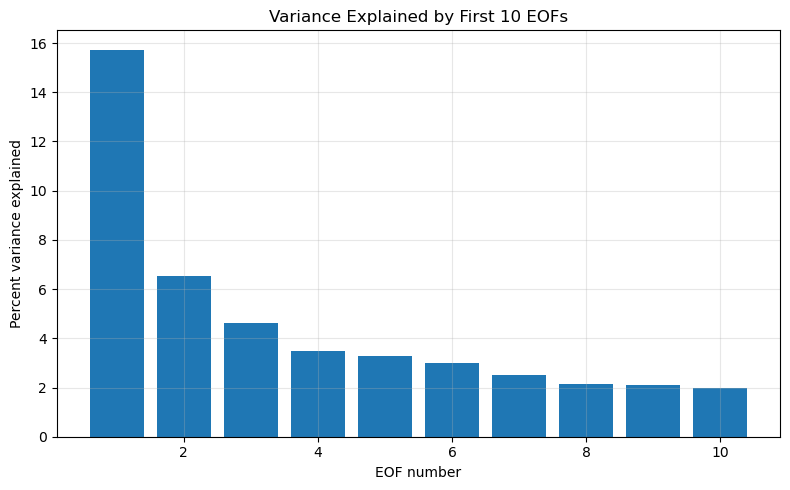

First 5 EOFs explain 33.6% of the total variance


In [59]:
# Visualization: EOF Maps and Variance Explained

# Plot maps of first 5 EOFs
fig, axes = plt.subplots(1, 5, figsize=(18, 4), constrained_layout=True, 
                        subplot_kw={'projection': ccrs.PlateCarree()})
if not isinstance(axes, np.ndarray):
    axes = [axes]

for i, ax in enumerate(axes):
    im = eof_maps.isel(mode=i).plot.pcolormesh(
        ax=ax,
        x='longitude', y='latitude',
        cmap='RdBu_r',
        add_colorbar=False,
        add_labels=False
    )
    ax.set_title(f'EOF {i+1}')
    ax.coastlines()
    plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046)

plt.suptitle("First 5 EOFs of SST Anomalies")
plt.show()

# Plot percent variance explained by first 10 EOFs
plt.figure(figsize=(8, 5))
plt.bar(np.arange(1, 11), variance_frac * 100)
plt.xlabel("EOF number")
plt.ylabel("Percent variance explained")
plt.title("Variance Explained by First 10 EOFs")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"First 5 EOFs explain {variance_frac[:5].sum()*100:.1f}% of the total variance")


Reconstructing SST field using first 5 EOFs...
Computing correlation...


/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


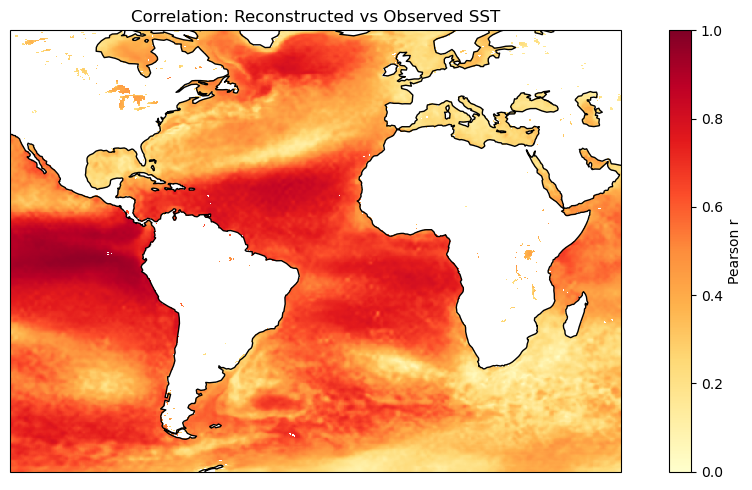

Mean correlation: 0.513
Max correlation: 0.958


In [60]:
# Reconstruct SST field using first 5 EOFs and compute correlation

print("Reconstructing SST field using first 5 EOFs...")

n_recon_eofs = 5

# Use the proper eofs method for reconstruction
reconstruction = solver.reconstructedField(n_recon_eofs)

# Compute correlation
print("Computing correlation...")
corr_map = xr.corr(reconstruction, sst_anom, dim='valid_time')

# Plot
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
corr_map.plot(ax=ax, vmin=0, vmax=1, cmap='YlOrRd', cbar_kwargs={'label': "Pearson r"})
ax.set_title("Correlation: Reconstructed vs Observed SST")
ax.coastlines()
plt.tight_layout()
plt.show()

print(f"Mean correlation: {corr_map.mean().values:.3f}")
print(f"Max correlation: {corr_map.max().values:.3f}")


Computing correlation between SST EOF1 and TCWV anomalies...
Computing PC1 manually...


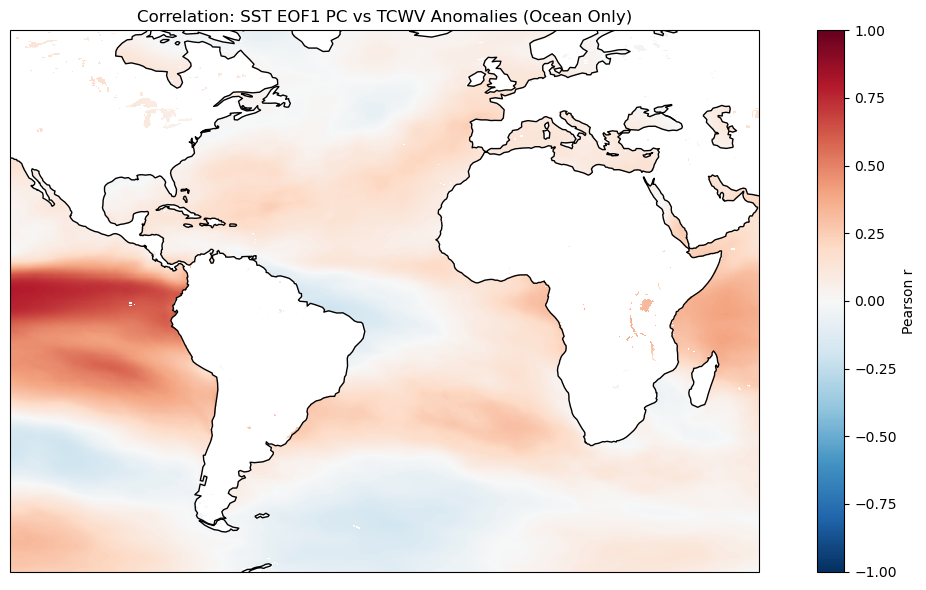

Mean correlation: 0.110
Max correlation: 0.793
Min correlation: -0.218
High positive correlation (>0.5) at 10448 grid points


In [ ]:
# 6) Correlation between SST EOF1 and TCWV anomalies

print("Computing correlation between SST EOF1 and TCWV anomalies...")

# Get the first EOF of SST
sst_eof1 = eof_maps.isel(mode=0)

# Compute PC1 manually: project data onto EOF1
print("Computing PC1 manually...")
# Use the same approach as reconstruction - project onto EOF1
sst_flat = sst_masked.stack(space=['latitude', 'longitude']).dropna('space')
eof1_flat = sst_eof1.stack(space=['latitude', 'longitude']).dropna('space')
pc1_data = (sst_flat.values @ eof1_flat.values)

# Create PC1 DataArray
sst_pc1 = xr.DataArray(
    pc1_data,
    dims=['valid_time'],
    coords={'valid_time': sst_anom['valid_time']}
)

# Get TCWV anomalies (detrended, deseasonalized, and standardized)
tcwv_anom = z['tcwv']  # This is the standardized TCWV anomalies

# Compute correlation between SST PC1 and TCWV anomalies at each grid point
tcwv_sst_corr = xr.corr(sst_pc1, tcwv_anom, dim='valid_time')

# Mask to ocean points only (where SST data exists)
tcwv_sst_corr_ocean = tcwv_sst_corr.where(spatial_mask)

# Plot the correlation map
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
im = tcwv_sst_corr_ocean.plot(
    ax=ax,
    vmin=-1, vmax=1,
    cmap='RdBu_r',
    cbar_kwargs={'label': "Pearson r"},
    add_colorbar=True
)
ax.set_title("Correlation: SST EOF1 PC vs TCWV Anomalies (Ocean Only)")
ax.coastlines()
plt.tight_layout()
plt.show()

print(f"Mean correlation (ocean): {tcwv_sst_corr_ocean.mean().values:.3f}")
print(f"Max correlation: {tcwv_sst_corr_ocean.max().values:.3f}")
print(f"Min correlation: {tcwv_sst_corr_ocean.min().values:.3f}")

# Check for interesting patterns
high_corr = tcwv_sst_corr_ocean.where(tcwv_sst_corr_ocean > 0.5)
low_corr = tcwv_sst_corr_ocean.where(tcwv_sst_corr_ocean < -0.5)

if high_corr.count() > 0:
    print(f"High positive correlation (>0.5) at {high_corr.count().values} grid points")
if low_corr.count() > 0:
    print(f"High negative correlation (<-0.5) at {low_corr.count().values} grid points")
